
The Tunisian Company of Electricity and Gas's problem is that it has faced many losses following the fraudulent activities from their customers.

The business question is:<br>
  - How can we detect fraudulent activities from our customers while still making our services satisfactory and increasing customer traffic?<br>
  
Our goal is to build an ML model that can learn from the payments of the clients whose payment activities are well known (using past data), so that we can predict which clients are highly likely to commit fraudulent activities.

In [27]:
import matplotlib.pyplot as plt
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE


warnings.simplefilter(action="ignore")


In [28]:
#The low_memory=False function is set as it prevents Pandas from determining which type the dtype of each column is set
## which can be very memory demanding.
client_test=pd.read_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/client_test.csv")

client_train=pd.read_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/client_train.csv")

invoice_test=pd.read_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/invoice_test.csv")

invoice_train=pd.read_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/invoice_train.csv")

In [29]:
client_train.shape,client_test.shape,invoice_train.shape,invoice_test.shape

((135493, 6), (58069, 5), (4476749, 16), (1939730, 16))

In [30]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [31]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [32]:
train=client_train.merge(invoice_train,on='client_id')
train.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.0,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.0,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.0,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.0,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.0,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   disrict               int64  
 1   client_id             object 
 2   client_catg           int64  
 3   region                int64  
 4   creation_date         object 
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        object 
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(15), object(5)
memory usage: 751.4+ MB


In [34]:
#checking for null values
train.isnull().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [35]:
#checking for duplicate data
train[train.duplicated()]

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
951893,60,train_Client_125864,11,101,29/12/1998,0.0,2011-12-12,11,101545,5,...,6,1,0,0,0,0,13680,13680,2,ELEC
1755798,62,train_Client_25894,11,301,16/06/1995,0.0,2010-07-13,40,6986740,5,...,6,1,0,0,0,0,0,0,2,GAZ
2137999,60,train_Client_3636,11,101,21/11/1988,0.0,2012-01-18,40,312650,5,...,6,1,0,0,0,0,623,623,2,GAZ
2163374,60,train_Client_37069,11,101,09/03/1990,0.0,2010-10-11,11,5284,5,...,6,1,0,0,0,0,99429,99429,2,ELEC
2433919,60,train_Client_44407,11,101,15/06/1989,1.0,2008-02-28,11,66921,5,...,6,1,0,0,0,0,0,0,2,ELEC
2805729,60,train_Client_54609,11,101,16/02/1994,0.0,2010-04-06,11,200912,5,...,6,1,0,0,0,0,0,0,2,ELEC
3260191,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3260198,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3394719,62,train_Client_7066,11,304,12/04/2013,0.0,2014-10-28,40,4463323,5,...,6,1,0,0,0,0,80,80,2,GAZ
3462929,60,train_Client_72519,11,101,03/06/1982,0.0,2013-01-21,11,246464,5,...,6,1,0,0,0,0,2954,2954,2,ELEC


In [36]:
train=train.drop_duplicates()

In [37]:
#converting to datetime
train['creation_date']=pd.to_datetime(train['creation_date'])
train['invoice_date']=pd.to_datetime(train['invoice_date'])

In [38]:
#dropping low cardinality data
train.drop(['client_id','creation_date','invoice_date'],axis=1,inplace=True)

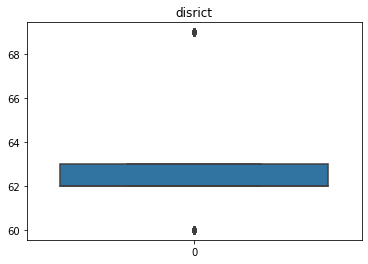

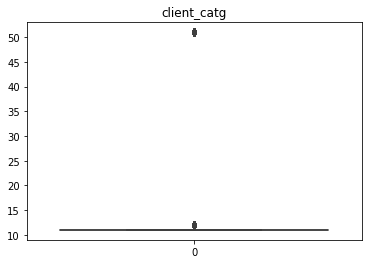

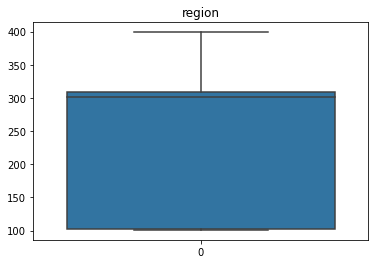

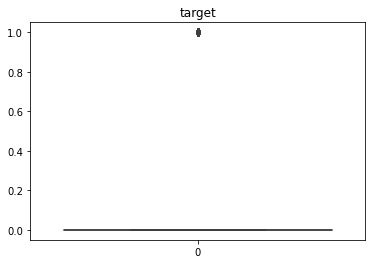

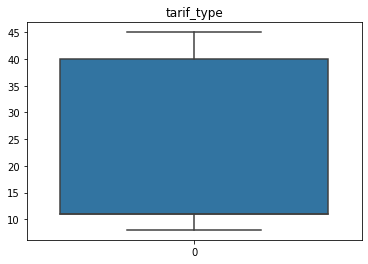

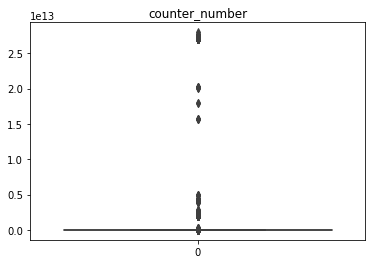

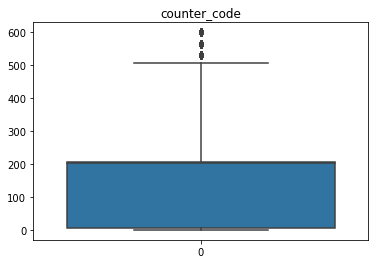

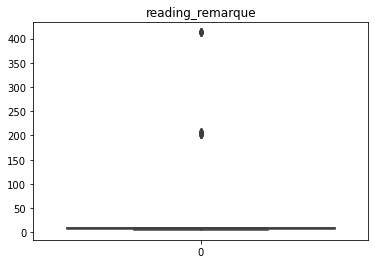

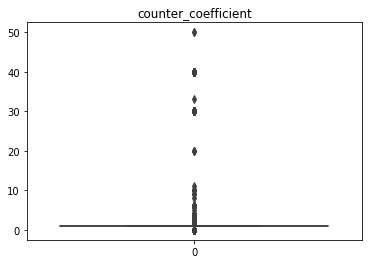

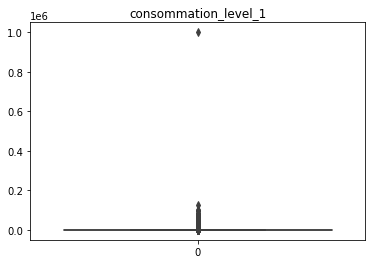

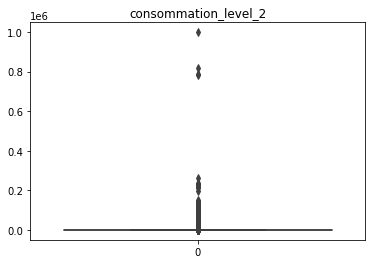

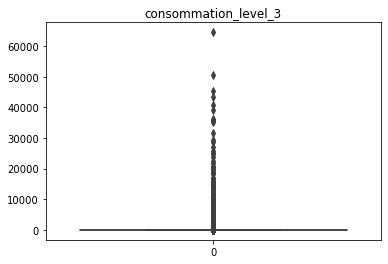

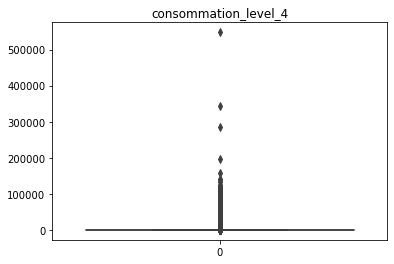

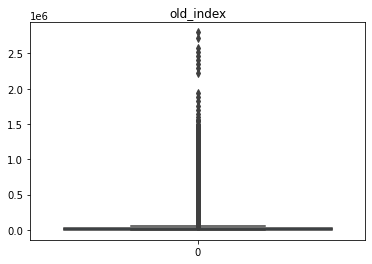

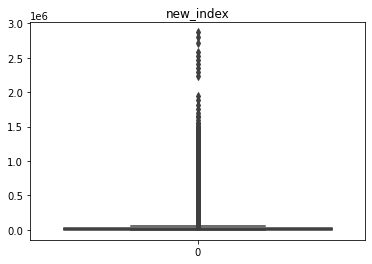

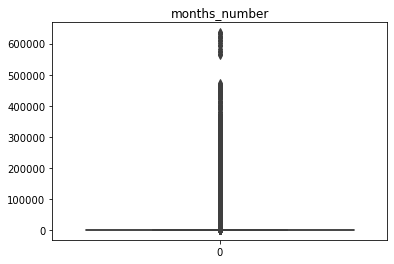

In [39]:
#checking for outliers
for i in train.select_dtypes(include='number'):
    plt.figure()
    sns.boxplot(train[i])
    plt.title(i)

In [40]:
#checking for rows with empty strings
def check_for_empty_strings(data,col):
    '''checking for rows with empty strings'''
    result=data.loc[np.where(data[col].apply(lambda x:x==' '))]
    return result

In [41]:
for i in train.columns:
    p= check_for_empty_strings(train,i)
    print('----------------\n',p)


----------------
 Empty DataFrame
Columns: [disrict, client_catg, region, target, tarif_type, counter_number, counter_statue, counter_code, reading_remarque, counter_coefficient, consommation_level_1, consommation_level_2, consommation_level_3, consommation_level_4, old_index, new_index, months_number, counter_type]
Index: []
----------------
 Empty DataFrame
Columns: [disrict, client_catg, region, target, tarif_type, counter_number, counter_statue, counter_code, reading_remarque, counter_coefficient, consommation_level_1, consommation_level_2, consommation_level_3, consommation_level_4, old_index, new_index, months_number, counter_type]
Index: []
----------------
 Empty DataFrame
Columns: [disrict, client_catg, region, target, tarif_type, counter_number, counter_statue, counter_code, reading_remarque, counter_coefficient, consommation_level_1, consommation_level_2, consommation_level_3, consommation_level_4, old_index, new_index, months_number, counter_type]
Index: []
----------------

<AxesSubplot:xlabel='target'>

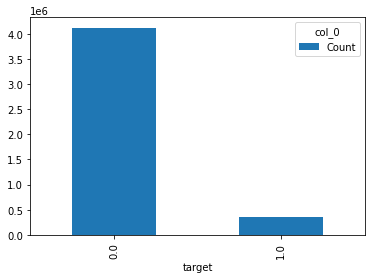

In [42]:
pd.crosstab(train['target'],'Count').plot(kind='bar')


In [43]:
train['target'].value_counts()
#our target classes are very unbalanced

0.0    4123629
1.0     353109
Name: target, dtype: int64

In [44]:
#encoding
cmap={'ELEC':0,'GAZ':1}
train['counter_type']=train['counter_type'].map(cmap)

In [45]:
to_drop=train.loc[train['counter_statue']=='A'].index

In [46]:
train.drop(to_drop,axis=0,inplace=True)

In [47]:
train['counter_statue']=train['counter_statue'].astype(float)

In [48]:
#modelling
xtrain=train.drop(['target'],axis=1)
ytrain=train['target']

In [49]:
xtrain.dtypes


disrict                   int64
client_catg               int64
region                    int64
tarif_type                int64
counter_number            int64
counter_statue          float64
counter_code              int64
reading_remarque          int64
counter_coefficient       int64
consommation_level_1      int64
consommation_level_2      int64
consommation_level_3      int64
consommation_level_4      int64
old_index                 int64
new_index                 int64
months_number             int64
counter_type              int64
dtype: object

### Cleaning test data

In [50]:
test=client_test.merge(invoice_test,on='client_id')
test=test.drop_duplicates()
#dropping low cardinality data
test.drop(['client_id','creation_date','invoice_date'],axis=1,inplace=True)
#encoding
cmap={'ELEC':0,'GAZ':1}
test['counter_type']=test['counter_type'].map(cmap)
to_drop=test.loc[test['counter_statue']=='A'].index
test.drop(to_drop,axis=0,inplace=True)
test['counter_statue']=test['counter_statue'].astype(float)

In [51]:
#saving cleaned datasets

In [52]:
test.to_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/cleaned_client_test.csv",index=False)
train.to_csv("/Users/USER/Documents/DATASETS/Zindi/electricity_fraud_detection/cleaned_client_train.csv",index=False)
